Import Dataset from Google Drive using Pydrive

In [1]:
#Importing Dataset using Pydrive
#Import Pydrive & Authenticate Google Drive
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


In [2]:
#Import Dataset Through Viweable link
link = 'https://drive.google.com/file/d/13rjUjizWHW4BvKaRdZdxNtdca7KcTb-l/view?usp=sharing'

import pandas as pd

# to get the id part of the file
id = link.split("/")[-2]

downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('Tweets.csv')

Load the Dataset as Pandas Dataframe


In [3]:
# import pandas as pd

df = pd.read_csv('Tweets.csv')

print(">>>>>>>>>>>>>>>>>>>> Description of Dataset <<<<<<<<<<<<<<<<<<<" )
print(df.describe())

print(">>>>>>>>>>>>>>>>>>>> Dataset <<<<<<<<<<<<<<<<<<<" )
print(df.head(5)) #display the first 5 column of Dataset. To view last column write df.tail()

print(">>>>>>>>>>>>>>>>>>>> Missing Values <<<<<<<<<<<<<<<<<<<" )
df.isnull().sum() #Check if there is any null value

>>>>>>>>>>>>>>>>>>>> Description of Dataset <<<<<<<<<<<<<<<<<<<
           tweet_id  ...  retweet_count
count  1.464000e+04  ...   14640.000000
mean   5.692184e+17  ...       0.082650
std    7.791112e+14  ...       0.745778
min    5.675883e+17  ...       0.000000
25%    5.685592e+17  ...       0.000000
50%    5.694779e+17  ...       0.000000
75%    5.698905e+17  ...       0.000000
max    5.703106e+17  ...      44.000000

[8 rows x 4 columns]
>>>>>>>>>>>>>>>>>>>> Dataset <<<<<<<<<<<<<<<<<<<
             tweet_id  ...               user_timezone
0  570306133677760513  ...  Eastern Time (US & Canada)
1  570301130888122368  ...  Pacific Time (US & Canada)
2  570301083672813571  ...  Central Time (US & Canada)
3  570301031407624196  ...  Pacific Time (US & Canada)
4  570300817074462722  ...  Pacific Time (US & Canada)

[5 rows x 15 columns]
>>>>>>>>>>>>>>>>>>>> Missing Values <<<<<<<<<<<<<<<<<<<


tweet_id                            0
airline_sentiment                   0
airline_sentiment_confidence        0
negativereason                   5462
negativereason_confidence        4118
airline                             0
airline_sentiment_gold          14600
name                                0
negativereason_gold             14608
retweet_count                       0
text                                0
tweet_coord                     13621
tweet_created                       0
tweet_location                   4733
user_timezone                    4820
dtype: int64

In [4]:
# Drop unnecessary Attributes.
df.drop(["tweet_id","airline_sentiment_confidence","negativereason","negativereason_confidence","airline","airline_sentiment_gold","name","negativereason_gold","retweet_count","tweet_coord","tweet_created","tweet_location","user_timezone"], axis = 1, inplace = True)
df.head()



,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [5]:
# Map alphabetical label into neumerical label
df["airline_sentiment"]= df["airline_sentiment"].map({'positive':1,'neutral':0,'negative':-1})
df.head()





,airline_sentiment,text
0,0,@VirginAmerica What @dhepburn said.
1,1,@VirginAmerica plus you've added commercials t...
2,0,@VirginAmerica I didn't today... Must mean I n...
3,-1,@VirginAmerica it's really aggressive to blast...
4,-1,@VirginAmerica and it's a really big bad thing...


In [6]:
airline_sentiment = df.airline_sentiment
print('Positive: ', airline_sentiment.isin([1]).sum())
print('Neutral: ',airline_sentiment.isin([0]).sum())
print('Negative: ',airline_sentiment.isin([-1]).sum())

Positive:  2363
Neutral:  3099
Negative:  9178


View frequency of sentiment through plot

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


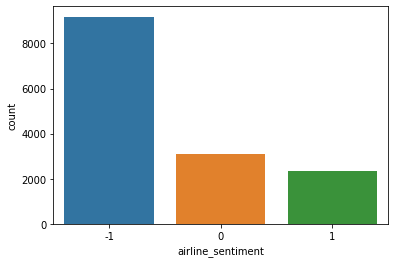

In [7]:
import seaborn as sns
sns_fig = sns.countplot("airline_sentiment", data = df)
sns_fig
import matplotlib.pyplot as plt
plt.savefig('fig2.pdf')

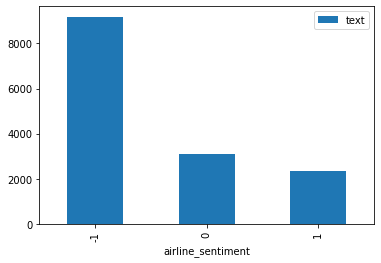

In [8]:
df.groupby("airline_sentiment").count().plot(kind = 'bar')

In [9]:
# pip install plotly
import plotly.express as px
fig = px.pie(df, names = "airline_sentiment")
fig.show()

In [10]:
###Downloading dependencies to save image
# pip install -U kaleido #Static image dependency 
##Orca downloading process on colab
# !pip install plotly>=4.7.1
# !wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
# !chmod +x /usr/local/bin/orca
# !apt-get install xvfb libgtk2.0-0 libgconf-2-4

In [11]:
##Save Image/Chart
# fig.write_image("df.pdf")

Import NLP libraries and tools for pre-processing

In [12]:
import re

import nltk #Natural Language Tool Kit for pre-processing
nltk.download('stopwords') #Stopwords removal
from nltk.corpus import stopwords
stopwords = stopwords.words("english")
stopwords.remove('not')
stopwords.remove('no')

nltk.download('wordnet') #To find Synonyme & Antonyme

#Lemmatization
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

#Stemming
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

#Non-English word removal
nltk.download('words')
english_words = set(nltk.corpus.words.words())


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


Pre-Processing/Cleaning Data

In [13]:
'''                Cleaning                   '''

lemma_cleaned_tweets = []
stemmed_cleaned_tweets = []

for i in range(len(df)):
    NonSymbolicTweet_i = re.sub("[^a-zA-Z]"," ",df['text'][i])
    LowerTweet_i = NonSymbolicTweet_i.lower()
    TokenizedWordsOfTweet_i = LowerTweet_i.split()
    #Lemmatization
    LemmaWordsOfTweet_i = [lemmatizer.lemmatize(w) for w in TokenizedWordsOfTweet_i if w  not in stopwords ]
    EnglishTweet = [w for w in LemmaWordsOfTweet_i if w in english_words]
    CleanedTweet_i = " ".join(EnglishTweet)
    lemma_cleaned_tweets.append(CleanedTweet_i)

    #Stemming
    StemWordsOfTweet_i = [stemmer.stem(w) for w in TokenizedWordsOfTweet_i if w  not in stopwords]
    stemmedEnglishTweet = [w for w in StemWordsOfTweet_i if w in english_words]
    stemmedCleanedTweet_i = " ".join(stemmedEnglishTweet)
    stemmed_cleaned_tweets.append(stemmedCleanedTweet_i)

In [14]:
'''                Vectorization                   '''
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
TfIdf = TfidfVectorizer() #object of Tf-Idf
cv = CountVectorizer() #object of BOW

#Bag of Words + Stemming features
X_cv_stem = cv.fit_transform(stemmed_cleaned_tweets).toarray()

#BOW + Lemmatization features
X_cv_lemma = cv.fit_transform(lemma_cleaned_tweets).toarray()

#Tf-Idf + Stemming features
X_TfIdf_stem = TfIdf.fit_transform(stemmed_cleaned_tweets).toarray()

#Tf-Idf + Lemmatization features
X_TfIdf_lemma = TfIdf.fit_transform(lemma_cleaned_tweets).toarray()

#Labels
y = df['airline_sentiment']

In [15]:
#Importing Classification Models
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# **MODEL BUILDING & DUMPTING**

In [18]:
from sklearn.model_selection import train_test_split
import joblib

'''1. Bag of Words + Stemming '''
X_train,X_test,y_train,y_test = train_test_split(X_cv_stem,y,test_size = .3, random_state = 146)

'''2. Bag of Words + Lemmatization'''
# X_train,X_test,y_train,y_test = train_test_split(X_cv_lemma,y,test_size = .3, random_state = 146)

'''3. TF-IDF + Stemming '''
# X_train,X_test,y_train,y_test = train_test_split(X_TfIdf_stem,y,test_size = .3, random_state = 146)

'''4. Tf-Idf + Lemmatization'''
# X_train,X_test,y_train,y_test = train_test_split(X_TfIdf_lemma,y,test_size = .3, random_state = 146)

'''                             MODEL BUILDING                             '''
SVCmodel = SVC().fit(X_train, y_train)
MNBmodel = MultinomialNB().fit(X_train, y_train)
GNBmodel = GaussianNB().fit(X_train,y_train)
DTmodel = DecisionTreeClassifier().fit(X_train, y_train)
RFmodel = RandomForestClassifier().fit(X_train, y_train)
LRmodel = LogisticRegression().fit(X_train, y_train)
KNNmodel = KNeighborsClassifier(n_neighbors = 5).fit(X_train, y_train)



'''                             MODEL DUMPING                             '''

'''1. BAG OF WORDS + STEMMING '''
joblib.dump(SVCmodel,'SVC_BS') # B means Bag Of Words , S means Stemming, T means Term frequency Inverse document frequency, L means Lemmatization
joblib.dump(MNBmodel,'MNB_BS')
joblib.dump(GNBmodel,'GNB_BS')
joblib.dump(DTmodel, 'DT_BS')
joblib.dump(RFmodel, 'RF_BS')
joblib.dump(LRmodel, 'LR_BS')

'''2.  BAG OF WORDS + LEMMATIZATION'''
# joblib.dump(SVCmodel,'SVC_BL')
# joblib.dump(MNBmodel,'MNB_BL')
# joblib.dump(GNBmodel,'GNB_BL')
# joblib.dump(DTmodel, 'DT_BL')
# joblib.dump(RFmodel, 'RF_BL')
# joblib.dump(LRmodel, 'LR_BL')

# '''3. TERM FREQUENCY - INVERSE DOCUMENT FREQUENCY + STEMMING'''
# joblib.dump(SVCmodel,'SVC_TS')
# joblib.dump(MNBmodel,'MNB_TS')
# joblib.dump(GNBmodel,'GNB_TS')
# joblib.dump(DTmodel, 'DT_TS')
# joblib.dump(RFmodel, 'RF_TS')
# joblib.dump(LRmodel, 'LR_TS')

'''4. TERM FREQUENCY - INVERSE DOCUMENT FREQUENCY + LEMMATIZATION'''
# joblib.dump(SVCmodel,'SVC_TL')
# joblib.dump(MNBmodel,'MNB_TL')
# joblib.dump(GNBmodel,'GNB_TL')
# joblib.dump(DTmodel, 'DT_TL')
# joblib.dump(RFmodel, 'RF_TL')
# joblib.dump(LRmodel, 'LR_TL')


'''                           DUMPING & BUILDING END                          '''

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



'                           DUMPING & BUILDING END                          '

# **JOBLIB MODEL LOADING**

In [20]:
#Import Classification evaluation metrices
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import joblib

#Algorithm + Bag of words + Stemming
svc_bs = joblib.load('SVC_BS')
mnb_bs = joblib.load('MNB_BS')
gnb_bs = joblib.load('GNB_BS')
dt_bs = joblib.load('DT_BS')
rf_bs = joblib.load('RF_BS')
lr_bs = joblib.load('LR_BS')
print("Algorithm + Bag of words + 'Stemming' Loaded")

# #Algorithm + Bag of words + Lemmatization
# svc_bl = joblib.load('SVC_BL')
# mnb_bl = joblib.load('MNB_BL')
# gnb_bl = joblib.load('GNB_BL')
# dt_bl = joblib.load('DT_BL')
# rf_bl = joblib.load('RF_BL')
# lr_bl = joblib.load('LR_BL')
# print("Algorithm + Bag of words + 'Lemmatization' Loaded")

# #Algorithm + Term frequency Inverse document frequency + Stemming 
# svc_ts = joblib.load('SVC_TS')
# mnb_ts = joblib.load('MNB_TS')
# gnb_ts = joblib.load('GNB_TS')
# dt_ts = joblib.load('DT_TS')
# rf_ts = joblib.load('RF_TS')
# lr_ts = joblib.load('LR_TS')
# print("Algorithm + Tf-Idf + 'Stemming' Loaded")

# # #Algorithm + Term frequency Inverse document frequency + Lemmatization
# svc_tl = joblib.load('SVC_TL')
# mnb_tl = joblib.load('MNB_TL')
# gnb_tl = joblib.load('GNB_TL')
# dt_tl = joblib.load('DT_TL')
# rf_tl = joblib.load('RF_TL')
# lr_tl = joblib.load('LR_TL')
# print("Algorithm + Tf-Idf + 'Lemmatization' Loaded")




Algorithm + Bag of words + 'Stemming' Loaded


# **JOBLIB PREDICTION & EVALUATION METRICES**

**Part 1**: Prediction of Bag of words + Stemming

In [21]:
print("                         ##### Part 1: BOW + STEMMING #####                                        ")
X_train,X_test,y_train,y_test = train_test_split(X_cv_stem,y,test_size = .3, random_state = 146)

print(">>>>>>>>>>>>>>     Support Vector Machine     <<<<<<<<<<<<")
pred = svc_bs.predict(X_test)
score = accuracy_score(y_test,pred)
print(score)
conf = confusion_matrix(y_test,pred)
print(conf)
report = classification_report(y_test,pred)
print(report)
print(" ")

print(">>>>>>>>>>>>>>     Multinomial Naive Bayes     <<<<<<<<<<<<")
pred = mnb_bs.predict(X_test)
score = accuracy_score(y_test,pred)
print(score)
conf = confusion_matrix(y_test,pred)
print(conf)
report = classification_report(y_test,pred)
print(report)
print(" ")

print(">>>>>>>>>>>>>>     Gaussian Naive Bayes     <<<<<<<<<<<<")
pred = gnb_bs.predict(X_test)
score = accuracy_score(y_test,pred)
print(score)
conf = confusion_matrix(y_test,pred)
print(conf)
report = classification_report(y_test,pred)
print(report)
print(" ")

print(">>>>>>>>>>>>>>     Decission Tree      <<<<<<<<<<<<")
pred = dt_bs.predict(X_test)
score = accuracy_score(y_test,pred)
print(score)
conf = confusion_matrix(y_test,pred)
print(conf)
report = classification_report(y_test,pred)
print(report)
print(" ")

print(">>>>>>>>>>>>>>     Random Forest     <<<<<<<<<<<<")
pred = rf_bs.predict(X_test)
score = accuracy_score(y_test,pred)
print(score)
conf = confusion_matrix(y_test,pred)
print(conf)
report = classification_report(y_test,pred)
print(report)
print(" ")

print(">>>>>>>>>>>>>>     Logistic Regression     <<<<<<<<<<<<")
pred = lr_bs.predict(X_test)
score = accuracy_score(y_test,pred)
print(score)
conf = confusion_matrix(y_test,pred)
print(conf)
report = classification_report(y_test,pred)
print(report)
print(" ")

                         ##### Part 1: BOW + STEMMING #####                                        
>>>>>>>>>>>>>>     Support Vector Machine     <<<<<<<<<<<<
0.7570582877959927
[[2501  182   56]
 [ 424  431   71]
 [ 222  112  393]]
              precision    recall  f1-score   support

          -1       0.79      0.91      0.85      2739
           0       0.59      0.47      0.52       926
           1       0.76      0.54      0.63       727

    accuracy                           0.76      4392
   macro avg       0.71      0.64      0.67      4392
weighted avg       0.75      0.76      0.74      4392

 
>>>>>>>>>>>>>>     Multinomial Naive Bayes     <<<<<<<<<<<<
0.7206284153005464
[[2430  218   91]
 [ 530  310   86]
 [ 221   81  425]]
              precision    recall  f1-score   support

          -1       0.76      0.89      0.82      2739
           0       0.51      0.33      0.40       926
           1       0.71      0.58      0.64       727

    accuracy                    

**Part 2**: Prediction of Bag of Words + Lemmatization

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_cv_lemma,y,test_size = .3, random_state = 146)

print("            ################## Bag Of Words & Lemmatization ###################          ")

print(">>>>>>>>>>>>>>     Support Vector Machine     <<<<<<<<<<<<")
pred = svc_bl.predict(X_test)
score = accuracy_score(y_test,pred)
print(score)
conf = confusion_matrix(y_test,pred)
print(conf)
report = classification_report(y_test,pred)
print(report)
print(" ")

print(">>>>>>>>>>>>>>     Multinomial Naive Bayes     <<<<<<<<<<<<")
pred = mnb_bl.predict(X_test)
score = accuracy_score(y_test,pred)
print(score)
conf = confusion_matrix(y_test,pred)
print(conf)
report = classification_report(y_test,pred)
print(report)
print(" ")

print(">>>>>>>>>>>>>>     Gaussian Naive Bayes     <<<<<<<<<<<<")
pred = gnb_bl.predict(X_test)
score = accuracy_score(y_test,pred)
print(score)
conf = confusion_matrix(y_test,pred)
print(conf)
report = classification_report(y_test,pred)
print(report)
print(" ")

print(">>>>>>>>>>>>>>     Decission Tree      <<<<<<<<<<<<")
pred = dt_bl.predict(X_test)
score = accuracy_score(y_test,pred)
print(score)
conf = confusion_matrix(y_test,pred)
print(conf)
report = classification_report(y_test,pred)
print(report)
print(" ")

print(">>>>>>>>>>>>>>     Random Forest     <<<<<<<<<<<<")
pred = rf_bl.predict(X_test)
score = accuracy_score(y_test,pred)
print(score)
conf = confusion_matrix(y_test,pred)
print(conf)
report = classification_report(y_test,pred)
print(report)
print(" ")

print(">>>>>>>>>>>>>>     Logistic Regression     <<<<<<<<<<<<")
pred = lr_bl.predict(X_test)
score = accuracy_score(y_test,pred)
print(score)
conf = confusion_matrix(y_test,pred)
print(conf)
report = classification_report(y_test,pred)
print(report)
print(" ")

            ################## Bag Of Words & Lemmatization ###################          
>>>>>>>>>>>>>>     Support Vector Machine     <<<<<<<<<<<<
0.7652550091074681
[[2502  191   46]
 [ 412  451   63]
 [ 216  103  408]]
              precision    recall  f1-score   support

          -1       0.79      0.91      0.85      2739
           0       0.59      0.47      0.52       926
           1       0.76      0.54      0.63       727

    accuracy                           0.76      4392
   macro avg       0.71      0.64      0.67      4392
weighted avg       0.75      0.76      0.74      4392

 
>>>>>>>>>>>>>>     Multinomial Naive Bayes     <<<<<<<<<<<<
0.7399817850637522
[[2474  191   74]
 [ 509  336   81]
 [ 218   69  440]]
              precision    recall  f1-score   support

          -1       0.79      0.91      0.85      2739
           0       0.59      0.47      0.52       926
           1       0.76      0.54      0.63       727

    accuracy                           0.7

**Part 3**: Prediction of Term frequency Inverse document frequency + *Stemming*

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_TfIdf_stem,y,test_size = .3, random_state = 146)
print("                         ###################Prediction of Term frequency Inverse document frequency + *Stemming* ########              ")

print(">>>>>>>>>>>>>>     Support Vector Machine     <<<<<<<<<<<<")
pred = svc_ts.predict(X_test)
score = accuracy_score(y_test,pred)
print(score)
conf = confusion_matrix(y_test,pred)
print(conf)
report = classification_report(y_test,pred)
print(report)
print(" ")

print(">>>>>>>>>>>>>>     Multinomial Naive Bayes     <<<<<<<<<<<<")
pred = mnb_ts.predict(X_test)
score = accuracy_score(y_test,pred)
print(score)
conf = confusion_matrix(y_test,pred)
print(conf)
report = classification_report(y_test,pred)
print(report)
print(" ")

print(">>>>>>>>>>>>>>     Gaussian Naive Bayes     <<<<<<<<<<<<")
pred = gnb_ts.predict(X_test)
score = accuracy_score(y_test,pred)
print(score)
conf = confusion_matrix(y_test,pred)
print(conf)
report = classification_report(y_test,pred)
print(report)
print(" ")

print(">>>>>>>>>>>>>>     Decission Tree      <<<<<<<<<<<<")
pred = dt_ts.predict(X_test)
score = accuracy_score(y_test,pred)
print(score)
conf = confusion_matrix(y_test,pred)
print(conf)
report = classification_report(y_test,pred)
print(report)
print(" ")

print(">>>>>>>>>>>>>>     Random Forest     <<<<<<<<<<<<")
pred = rf_ts.predict(X_test)
score = accuracy_score(y_test,pred)
print(score)
conf = confusion_matrix(y_test,pred)
print(conf)
report = classification_report(y_test,pred)
print(report)
print(" ")

print(">>>>>>>>>>>>>>     Logistic Regression     <<<<<<<<<<<<")
pred = lr_ts.predict(X_test)
score = accuracy_score(y_test,pred)
print(score)
conf = confusion_matrix(y_test,pred)
print(conf)
report = classification_report(y_test,pred)
print(report)
print(" ")


                         ###################Prediction of Term frequency Inverse document frequency + *Stemming* ########              
>>>>>>>>>>>>>>     Support Vector Machine     <<<<<<<<<<<<
0.7550091074681239
[[2582  108   49]
 [ 522  329   75]
 [ 243   79  405]]
              precision    recall  f1-score   support

          -1       0.79      0.91      0.85      2739
           0       0.59      0.47      0.52       926
           1       0.76      0.54      0.63       727

    accuracy                           0.76      4392
   macro avg       0.71      0.64      0.67      4392
weighted avg       0.75      0.76      0.74      4392

 
>>>>>>>>>>>>>>     Multinomial Naive Bayes     <<<<<<<<<<<<
0.6953551912568307
[[2692   38    9]
 [ 740  152   34]
 [ 478   39  210]]
              precision    recall  f1-score   support

          -1       0.79      0.91      0.85      2739
           0       0.59      0.47      0.52       926
           1       0.76      0.54      0.63       7

**Part 4**: Prediction of Term frequency - Inverse document frequency  + Lemmatization

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X_TfIdf_lemma,y,test_size = .3, random_state = 146)
print("    #### Prediction of Tf-Idf + Lemmatization ####     ")

print(">>>>>>>>>>>>>>     Support Vector Machine     <<<<<<<<<<<<")
pred = svc_tl.predict(X_test)
score = accuracy_score(y_test,pred)
print(score)
conf = confusion_matrix(y_test,pred)
print(conf)
report = classification_report(y_test,pred)
print(report)
print(" ")

print(">>>>>>>>>>>>>>     Multinomial Naive Bayes     <<<<<<<<<<<<")
pred = mnb_tl.predict(X_test)
score = accuracy_score(y_test,pred)
print(score)
conf = confusion_matrix(y_test,pred)
print(conf)
report = classification_report(y_test,pred)
print(report)
print(" ")

print(">>>>>>>>>>>>>>     Gaussian Naive Bayes     <<<<<<<<<<<<")
pred = gnb_tl.predict(X_test)
score = accuracy_score(y_test,pred)
print(score)
conf = confusion_matrix(y_test,pred)
print(conf)
report = classification_report(y_test,pred)
print(report)
print(" ")

print(">>>>>>>>>>>>>>     Decission Tree      <<<<<<<<<<<<")
pred = dt_tl.predict(X_test)
score = accuracy_score(y_test,pred)
print(score)
conf = confusion_matrix(y_test,pred)
print(conf)
report = classification_report(y_test,pred)
print(report)
print(" ")

print(">>>>>>>>>>>>>>     Random Forest     <<<<<<<<<<<<")
pred = rf_tl.predict(X_test)
score = accuracy_score(y_test,pred)
print(score)
conf = confusion_matrix(y_test,pred)
print(conf)
report = classification_report(y_test,svc_bs_pred)
print(report)
print(" ")

print(">>>>>>>>>>>>>>     Logistic Regression     <<<<<<<<<<<<")
pred = lr_tl.predict(X_test)
score = accuracy_score(y_test,pred)
print(score)
conf = confusion_matrix(y_test,pred)
print(conf)
report = classification_report(y_test,pred)
print(report)
print(" ")

    #### Prediction of Tf-Idf + Lemmatization ####     
>>>>>>>>>>>>>>     Support Vector Machine     <<<<<<<<<<<<
0.7663934426229508
[[2618   85   36]
 [ 534  334   58]
 [ 253   60  414]]
              precision    recall  f1-score   support

          -1       0.79      0.91      0.85      2739
           0       0.59      0.47      0.52       926
           1       0.76      0.54      0.63       727

    accuracy                           0.76      4392
   macro avg       0.71      0.64      0.67      4392
weighted avg       0.75      0.76      0.74      4392

 
>>>>>>>>>>>>>>     Multinomial Naive Bayes     <<<<<<<<<<<<
0.6985428051001822
[[2703   28    8]
 [ 754  147   25]
 [ 473   36  218]]
              precision    recall  f1-score   support

          -1       0.79      0.91      0.85      2739
           0       0.59      0.47      0.52       926
           1       0.76      0.54      0.63       727

    accuracy                           0.76      4392
   macro avg       0.7

In [ ]:
# print(f"LogisticR: {LRmodel.score(X_test,y_test)*100}, SVC:{SVCmodel.score(X_test,y_test)*100}, Naive Bayes: {NBmodel.score(X_test,y_test)*100},KNN: {KNNmodel.score(X_test,y_test)*100},  Decission Tree: {DTmodel.score(X_test,y_test)*100}, Random Forest: {RFmodel.score(X_test,y_test)*100 :.2f} ")